# Sentence Transformer Embedding based Topics Modelling and Prediction

Importing Libraries
--

In [1]:
from pre_process import *

Loading Libraries...Just a moment please!...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading dataset
--

In [2]:
path = "/Users/gurpreetbedi/Downloads/Neural/Indeed_local/source_data/"

In [3]:
art_train = load_data(f"{path}article.json")
art_test = load_data(f"{path}pred_article.json")

art_test["cont_title"] = art_test["contentTitle"] + " " +art_test["content"]
art_train["cont_title"] = art_train["contentTitle"] + " " +art_train["content"]

art_test = remove_hyperlinks_html_tags(art_test, "cont_title")
art_train = remove_hyperlinks_html_tags(art_train, "cont_title")

Shape of pre-processed data
--

In [5]:
print("After pre-processing the raw data: ")
print(f'Shape of the article from taining corpus: {art_train.shape}')
print(f'Shape of the article from test corpus: {art_test.shape}')

After pre-processing the raw data: 
Shape of the article from taining corpus: (13639, 8)
Shape of the article from test corpus: (1417, 7)


Load sentence ransformer embeddings
--

In [6]:
content = list(art_train["cont_title"])
title = list(art_train['contentTitle'])

In [7]:
embedding_model = "msmarco-MiniLM-L-12-v3"
device = "cuda" if torch.cuda.is_available else "cpu"
sent_embeddings = Sentence_Encoder(embedding_model).embed_documents(content, device=device)

In [8]:
print(f'Shape of Sentence Transformer embeddings of the articles from training corpus : {art_train.shape}')

Shape of Sentence Transformer embeddings of the articles from training corpus : (13639, 8)


Perform dimensionality reduction and document clustering
--

In [9]:
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=10,
                       metric='cosine')

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=30,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)

umap_data = umap_model.fit_transform(sent_embeddings)
cluster = hdbscan_model.fit(umap_data)

In [10]:
print(f"The number of unqiue topics from HDBSCAN model: {len(np.unique(cluster.labels_))}")

The number of unqiue topics from HDBSCAN model: 74


Save the model for future reference
--

In [11]:
joblib.dump(umap_model, f"/Users/gurpreetbedi/Downloads/Neural/models/umap_model_{len(np.unique(cluster.labels_))}.sav")
joblib.dump(hdbscan_model, f"/Users/gurpreetbedi/Downloads/Neural/models/hdbscan_model_{len(np.unique(cluster.labels_))}.sav")

['/Users/gurpreetbedi/Downloads/Neural/models/hdbscan_model_74.sav']

Different Visualizations of Clustered data
--

8491 5148


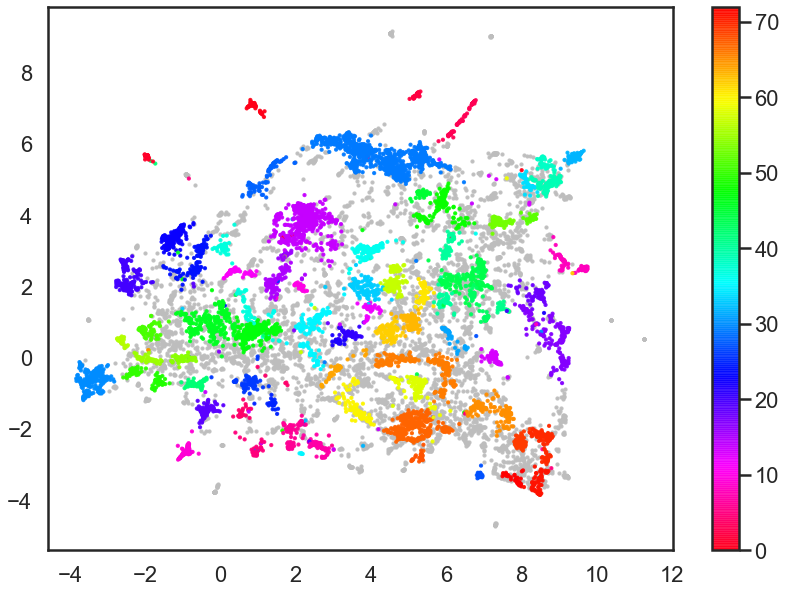

In [12]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(sent_embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5, alpha=0.9)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r', alpha=0.9)

print(len(clustered), len(outliers))
plt.colorbar()

Scatter plot to show points in space
--

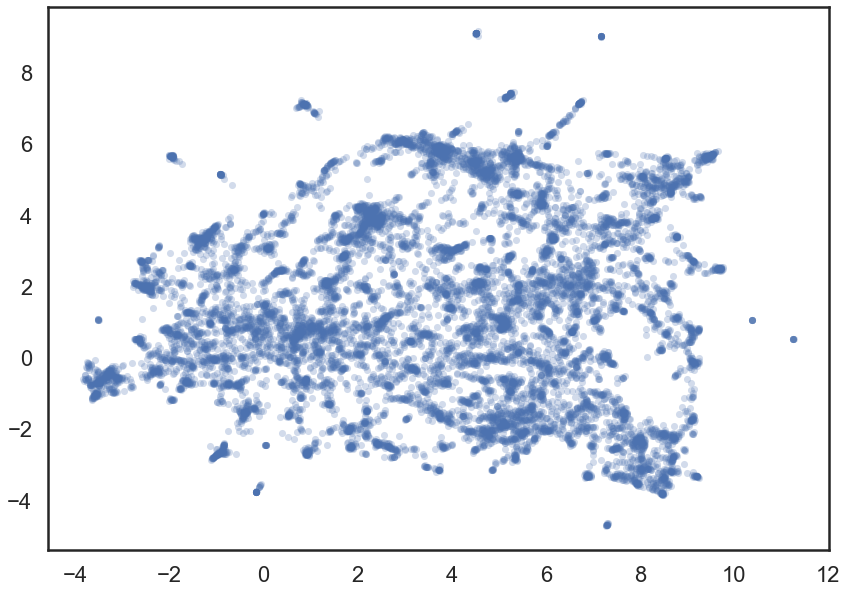

In [13]:
plt.scatter(*umap_data.T, s=50, linewidth=0, c='b', alpha=0.25)

Condensed Tree Plot from HDBSCAN
--

<AxesSubplot:ylabel='$\\lambda$ value'>

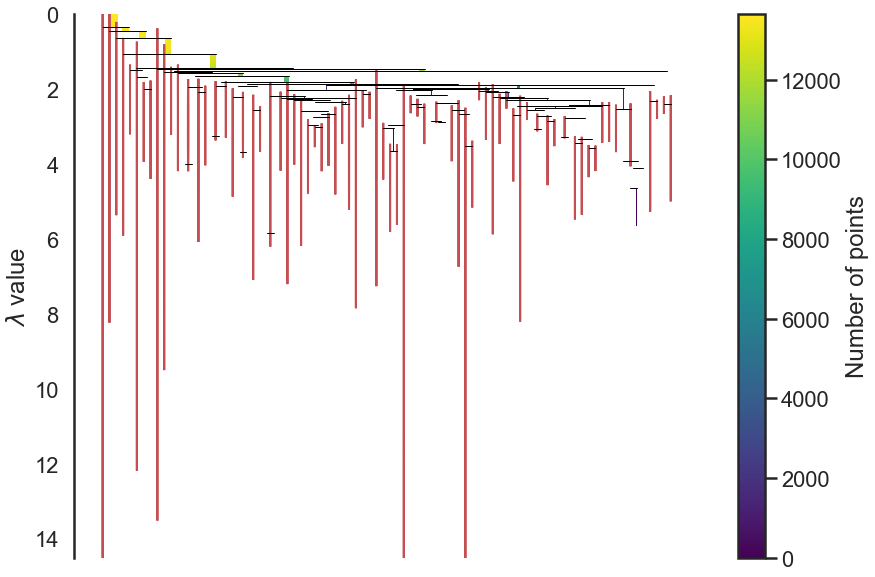

In [14]:
cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette("deep",8))

Soft Clustering of the topics in space
--

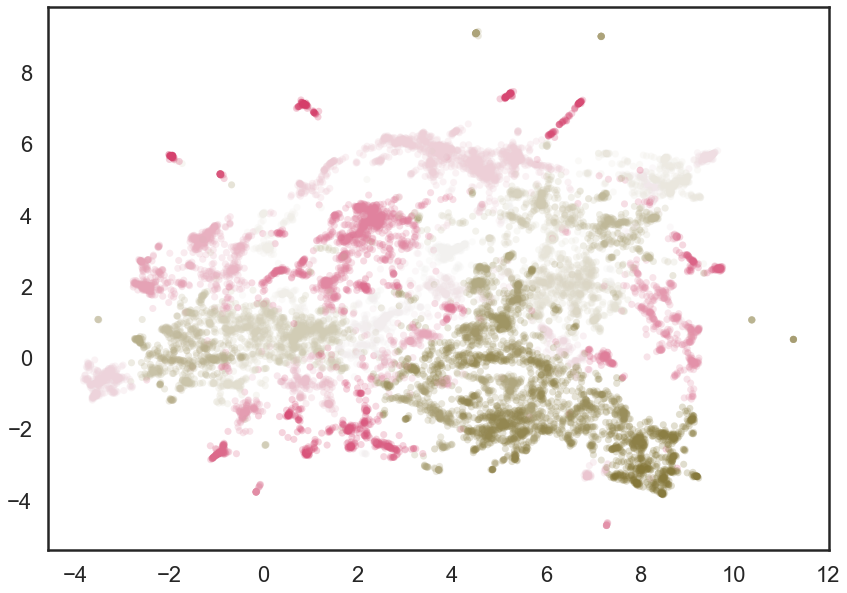

In [15]:
soft_clusters = hdbscan.all_points_membership_vectors(cluster)

color_palette = sns.diverging_palette(0, len(np.unique(clustered.labels)), n=len(np.unique(clustered.labels)))
cluster_colors = [color_palette[np.argmax(x)] for x in soft_clusters]

plt.scatter(*umap_data.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

Assigning Labels from Clustering to the documents
--

In [16]:
docs_df = pd.DataFrame(content, columns=["Doc"])
docs_df['Title'] = title
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

Topic based TF-IDF
--

In [17]:
def doc_tf_idf(documents, doc_length, ngram_range=(1,1)):
    """
    topic based TF-IDF to create dense clusters allowing for easily interpretable topics
    """
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(documents)
    terms = count.transform(documents).toarray()
    words = np.sum(terms, axis=1)
    tf = terms.T/words
    sum_terms = np.sum(terms, axis=0)
    idf = np.log(doc_length/sum_terms).reshape(-1, 1)
    tf_idf = tf * idf
    return tf_idf, count
  
tf_idf, count = doc_tf_idf(docs_per_topic.Doc.values, doc_length=len(content), ngram_range=(1,2))

In [18]:
print(f"TF-IDF Shape: {tf_idf.shape}")

TF-IDF Shape: (2966976, 74)


Creating topic words from topic numbers
--

In [19]:
def get_top_n_words(tf_idf, count, docs_per_topic, n=20):
    """
    Get the top words per topic
    """      
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_10_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_10_words

def get_topic_sizes(df):
    """
    Get the document counts clustered for all the topics.
    """    
    topic_sizes = (df.groupby(['Topic']).Doc.count().reset_index()
                   .rename({"Topic": "Topic", "Doc": "Doc_Count"}, axis='columns').sort_values("Doc_Count", ascending=False))
    return topic_sizes

top_10_words = get_top_n_words(tf_idf, count, docs_per_topic, n=10)
topic_sizes = get_topic_sizes(docs_df)
topic_sizes.head(10)

Topic  Doc_Count
0      -1       5148
30     29        939
15     14        582
68     67        322
31     30        296
48     47        262
47     46        243
24     23        224
18     17        210
21     20        201

Top 4 topics with maximum size
--

In [20]:
top_10_words[29], top_10_words[14], top_10_words[67], top_10_words[30]

([('interview questions', 0.003011646650047275),
  ('interviewer', 0.0027794625023647534),
  ('answers', 0.0022903916474813833),
  ('question', 0.002235725084142519),
  ('interviewers', 0.001928799117076145),
  ('sample answers', 0.0016618901546861205),
  ('answer', 0.001589157356496385),
  ('ask question', 0.0015774032284199594),
  ('describe', 0.0015122034192217907),
  ('interviews', 0.001483933849927124)],
 [('objective', 0.003152735722873133),
  ('resume objective', 0.003149335509335285),
  ('resumes', 0.0027350619706198375),
  ('cv', 0.0024979666399042658),
  ('summary', 0.002409547501791559),
  ('section', 0.001994105299490516),
  ('keywords', 0.001969831482534228),
  ('accomplishments', 0.0017962974162655523),
  ('format', 0.001785310631413443),
  ('awards', 0.001715506055359842)],
 [('target', 0.0030765529407491567),
  ('consumers', 0.0027516478089034306),
  ('selling', 0.002585651650525218),
  ('segmentation', 0.0023000932441281036),
  ('marketing strategy', 0.0022703414377105

Heatmap for top 30 topics
--

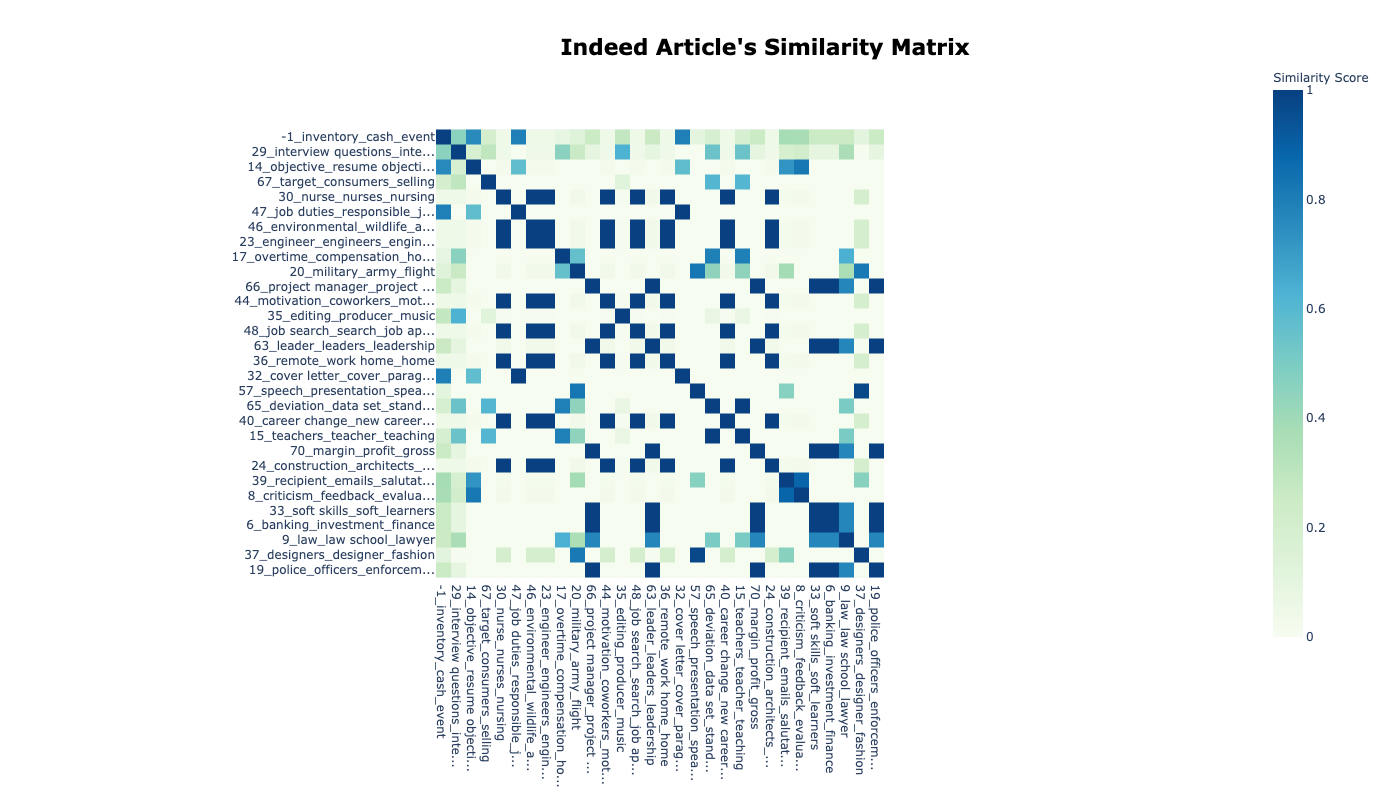

In [23]:
df = pd.DataFrame(topic_sizes).reset_index()
df = df.drop(columns=["index"])
topics = df.Topic.values.tolist()[:30]
fig, _= heatmap_visualization(tf_idf, topics, top_10_words)
fig

Heatmap for all topics
--

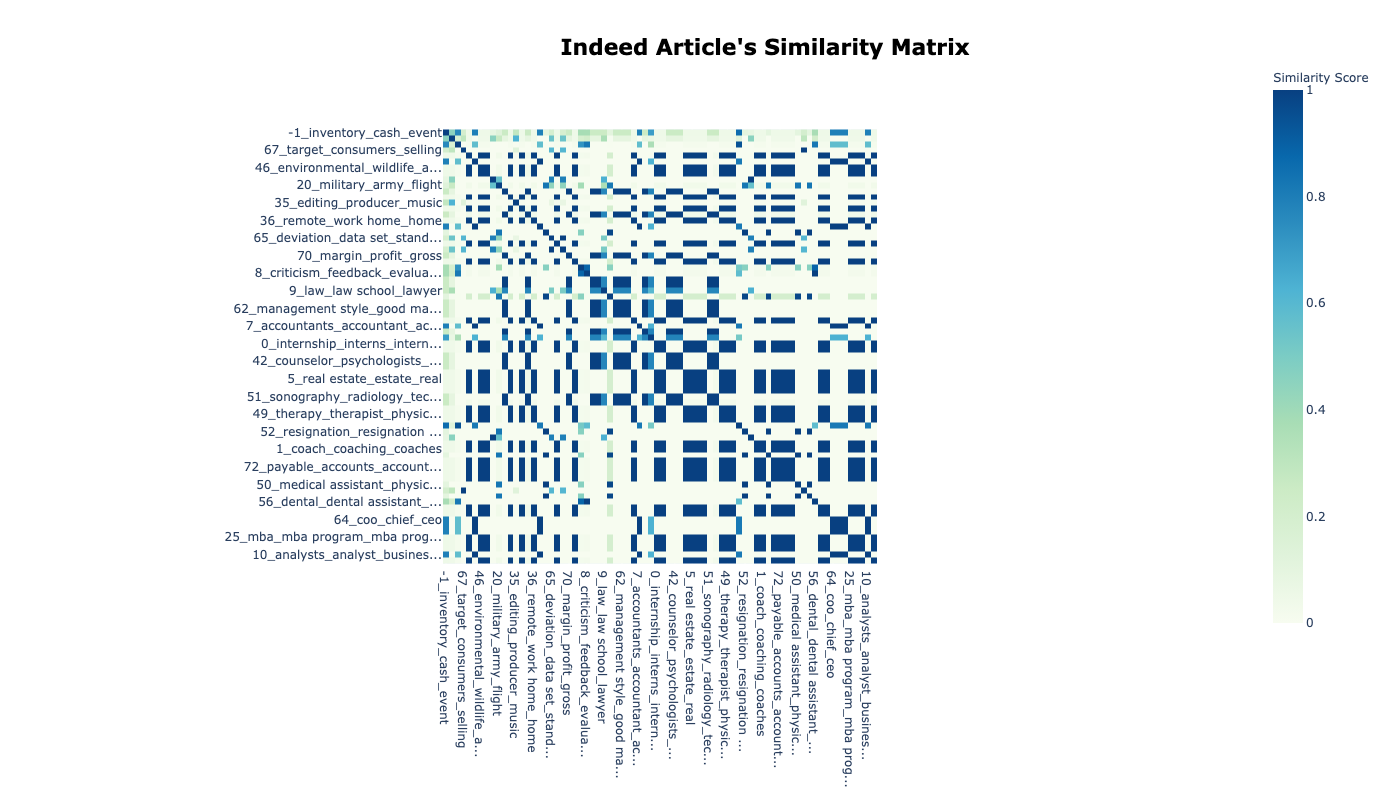

In [24]:
df = pd.DataFrame(topic_sizes).reset_index()
df = df.drop(columns=["index"])
topics = df.Topic.values.tolist()
fig, _= heatmap_visualization(tf_idf, topics, top_10_words)
fig

2-D Plotly Visualization of topics in Space
--

In [25]:
def get_colors(topics, topic_list):
    """
    Get the color marker for the topics inside the topics list
    """          
    if topics == -1:
        marker = ["#B0BEC5" for _ in topic_list[1:]]
    else:
        marker = ["red" if topic == topics else "#B0BEC5" for topic in topic_list[1:]]
    return [{'marker_color': [marker]}]   

def get_topic(topic):
    """
    Get a particular topic from all the topics
    """           
    return top_10_words[topic]

def get_topics():         
    """
    Get a all the topics in a dictionary
    """          
    return top_10_words

def get_topic_freq(topic= None):
    """
    Get document count per topic which will be the size of the topic
    """    
    if isinstance(topic, int):
        return topic_sizes[topic]
    else:
        return topic_sizes
    
def topic_visualization_fotmatting(df, topic_list, width, height):
    """
    Format topic visulization using the co-ordinates provided in the datafarme and list of topics
    """
    # Prepare figure range
    x_range = (df.x.min() - abs((df.x.min()) * .15), df.x.max() + abs((df.x.max()) * .15))
    y_range = (df.y.min() - abs((df.y.min()) * .15), df.y.max() + abs((df.y.max()) * .15))

    # Plot topics
    fig = px.scatter(df, x="x", y="y", size="Size", size_max=40, template="simple_white", labels={"x": "", "y": ""},
                     hover_data={"x": False, "y": False, "Topic": True, "Words": True, "Size": True})
    fig.update_traces(marker=dict(color="#7f91eb", line=dict(width=2, color='DarkSlateGrey'))) #"#B0BEC5"

    # Update hover order
    fig.update_traces(hovertemplate="<br>".join(["<b>Topic %{customdata[0]}</b>",
                                                 "Words: %{customdata[1]}",
                                                 "Count: %{customdata[2]}"]))   
    
    # Create a slider for topic selection
    steps = [dict(label=f"Topic {topic}", method="update", args=get_colors(topic,topic_list)) for topic in topic_list[1:]]
    sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

    # Stylize layout
    fig.update_layout(
                        title={'text': "<b>Indeed's Intertopic Distance", 'y': .95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': dict(size=22,color="Black")},
                        width=width,
                        height=height,
                        hoverlabel=dict(
                            bgcolor="white",
                            font_size=14,
                            font_family="Rockwell"
        ),
        xaxis={"visible": False},
        yaxis={"visible": False},
        sliders=sliders
    )

    fig.update_xaxes(range=x_range)
    fig.update_yaxes(range=y_range)


    fig.add_shape(type="line",
                  x0=sum(x_range)/2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color="#CFD8DC", width=2))
    fig.add_shape(type="line",
                  x0=x_range[0], y0=sum(y_range)/2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color="#9E9E9E", width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text="D1", showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text="D2", showarrow=False, xshift=10)
    fig.data = fig.data[::-1]

    return fig

In [26]:
def topics_viz_data(topics, width, height):
    """
    Creates Topic Visalization in 2D space. Each topic taking shape as the sice of the documents clustered in each topic
    """       
    topics = sorted(list(get_topics().keys()))
    frequencies = [topic_sizes[topic_sizes["Topic"]==topic]["Doc_Count"].values[0] for topic in topics]
    words = [" | ".join([word[0] for word in get_topic(topic)[:5]]) for topic in topics]

    indices = np.array([topics.index(topic) for topic in topics])

    embeddings = tf_idf[indices]
    embeddings = MinMaxScaler().fit_transform(embeddings)
    embeddings = umap.UMAP(n_neighbors=2, n_components=2, metric='hellinger').fit_transform(embeddings)

    df = pd.DataFrame({"x": embeddings[1:, 0], "y": embeddings[1:, 1],
                       "Topic": topics[1:], "Words": words[1:], "Size": frequencies[1:]})
    fig = topic_visualization_fotmatting(df, topics, width, height)

    return fig, embeddings, df


In [27]:
def visualize_topics(topics = None, width = 1000, height = 1000):
    """
    Format topic visulization using the co-ordinates provided in the datafarme and list of topics
    """    
    fig,_,_= topics_viz_data(topics=topics,
                             width=width,
                             height=height)
    return fig

In [28]:
topics = docs_per_topic.Topic.tolist()
fig = visualize_topics(topics)

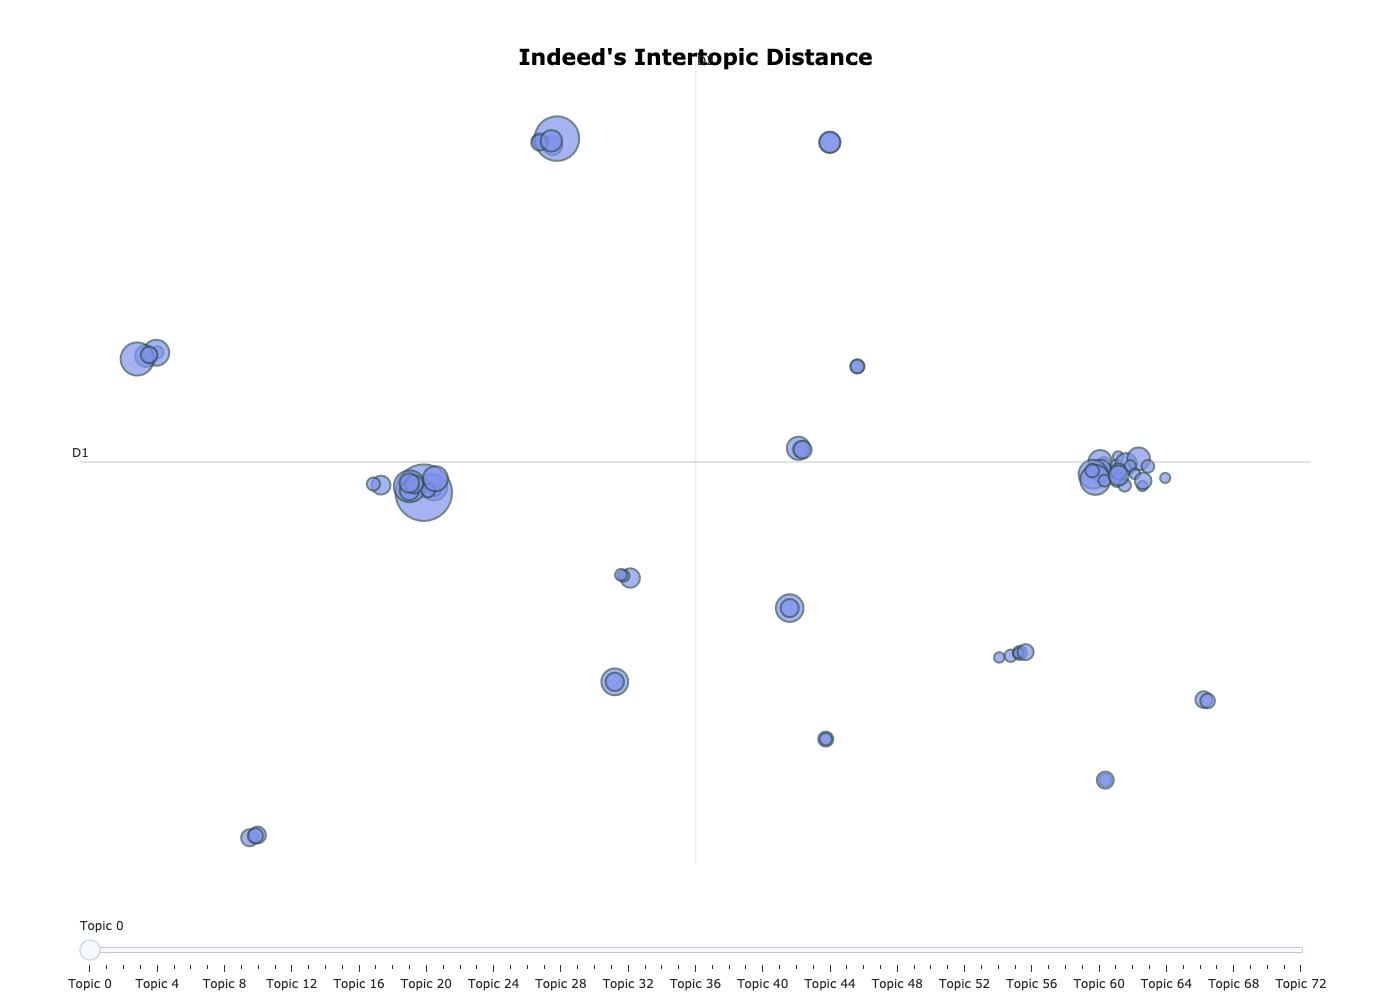

In [29]:
fig

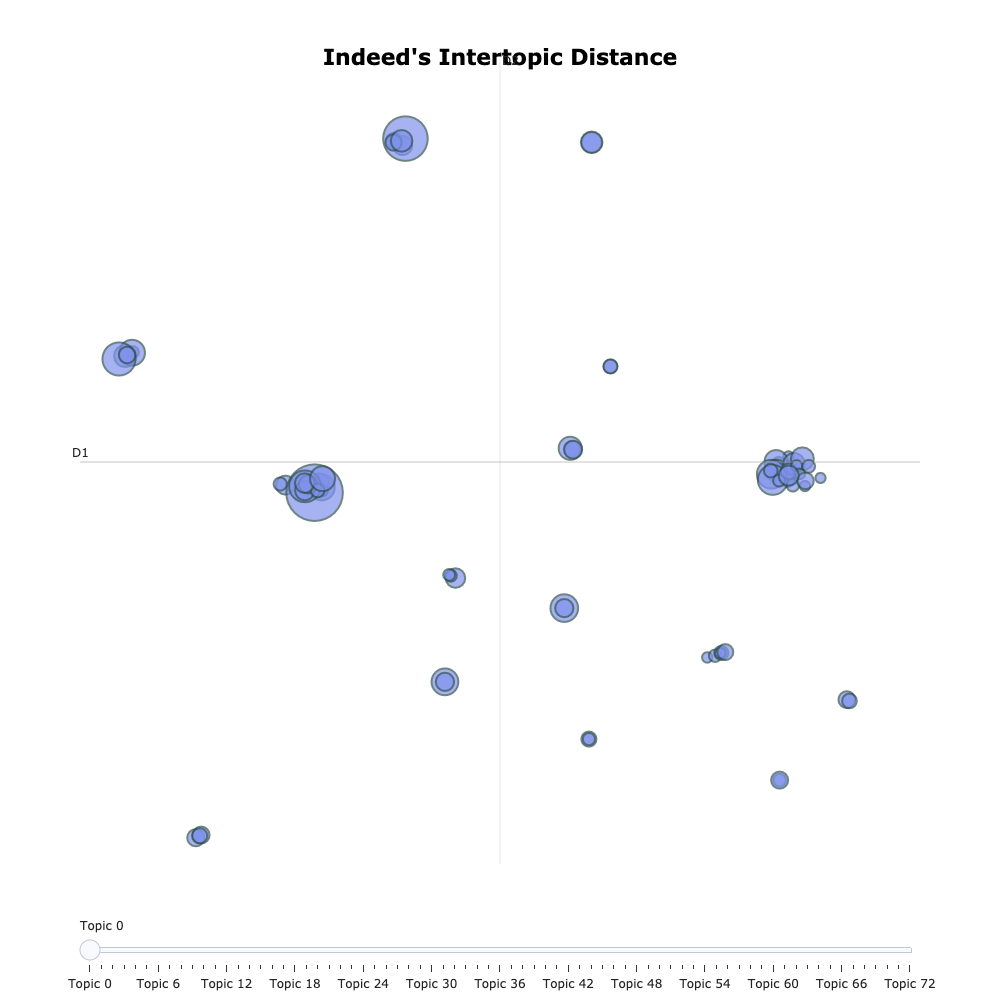

In [30]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (9).png") 

**Note: This figure is interactive, know plotly issue due to which the figure is not visible on Github.**

Topic Dendograms depicting the hierarchy of topics
--

In [31]:
def topics_dendrogram(embeddings, orientation="left", width = 1000, height = 1000):
    """
    Creates a Dendogram in topic space using sentence transformer embeddings
    """    
    embeddings = np.array(embeddings)
    topics_list = sorted(list(get_topics().keys()))
    topics_lookup = {topic:i for i, topic in enumerate(topics_list)}
    indices = np.array([topics_lookup[topic] for topic in topics_list])
    embeddings = embeddings[indices]

    # Create dendogram
    distance_matrix = 1 - cosine_similarity(embeddings)
    fig = ff.create_dendrogram(distance_matrix,
                               orientation=orientation,
                               linkagefun=lambda x: linkage(x, "ward"),
                               color_threshold=1)

    # Create nicer labels
    axis = "yaxis" if orientation == "left" else "xaxis"
    new_labels = [[[str(topics_list[int(x)]), None]] + get_topic(topics_list[int(x)])
                  for x in fig.layout[axis]["ticktext"]]
    new_labels = ["_".join([label[0] for label in labels[:4]]) for labels in new_labels]
    new_labels = [label if len(label) < 30 else label[:27] + "..." for label in new_labels]

    # Stylize layout
    fig.update_layout(plot_bgcolor="#ECEFF1",
                      template="plotly_white",
                      title={'text': "<b>Indeed's Article Clustering", "y": .95, "x": 0.5, "xanchor": 'center', "yanchor": "top", "font": dict(size=22, color="Black")},
                      width=width,
                      height=height,
                      hoverlabel=dict(bgcolor="white", font_size=16,font_family="Rockwell"),

    )

    # Stylize orientation
    if orientation == "left":
        fig.update_layout(yaxis=dict(tickmode="array",
                                     ticktext=new_labels))
    else:
        fig.update_layout(xaxis=dict(tickmode="array",
                                     ticktext=new_labels))
    return fig

Create Topic embeddings
--

In [32]:
def create_topic_embeddings(embeddings):
    topic_list = list(get_topics().keys())
    topic_list.sort()
    topic_embeddings = []
    for i, topic in enumerate(topic_list):
        indexes = np.array(docs_df[docs_df["Topic"]==topic].index)
        topic_embedding = np.average(embeddings[indexes], axis=0)
        topic_embeddings.append(topic_embedding)
    return topic_embeddings

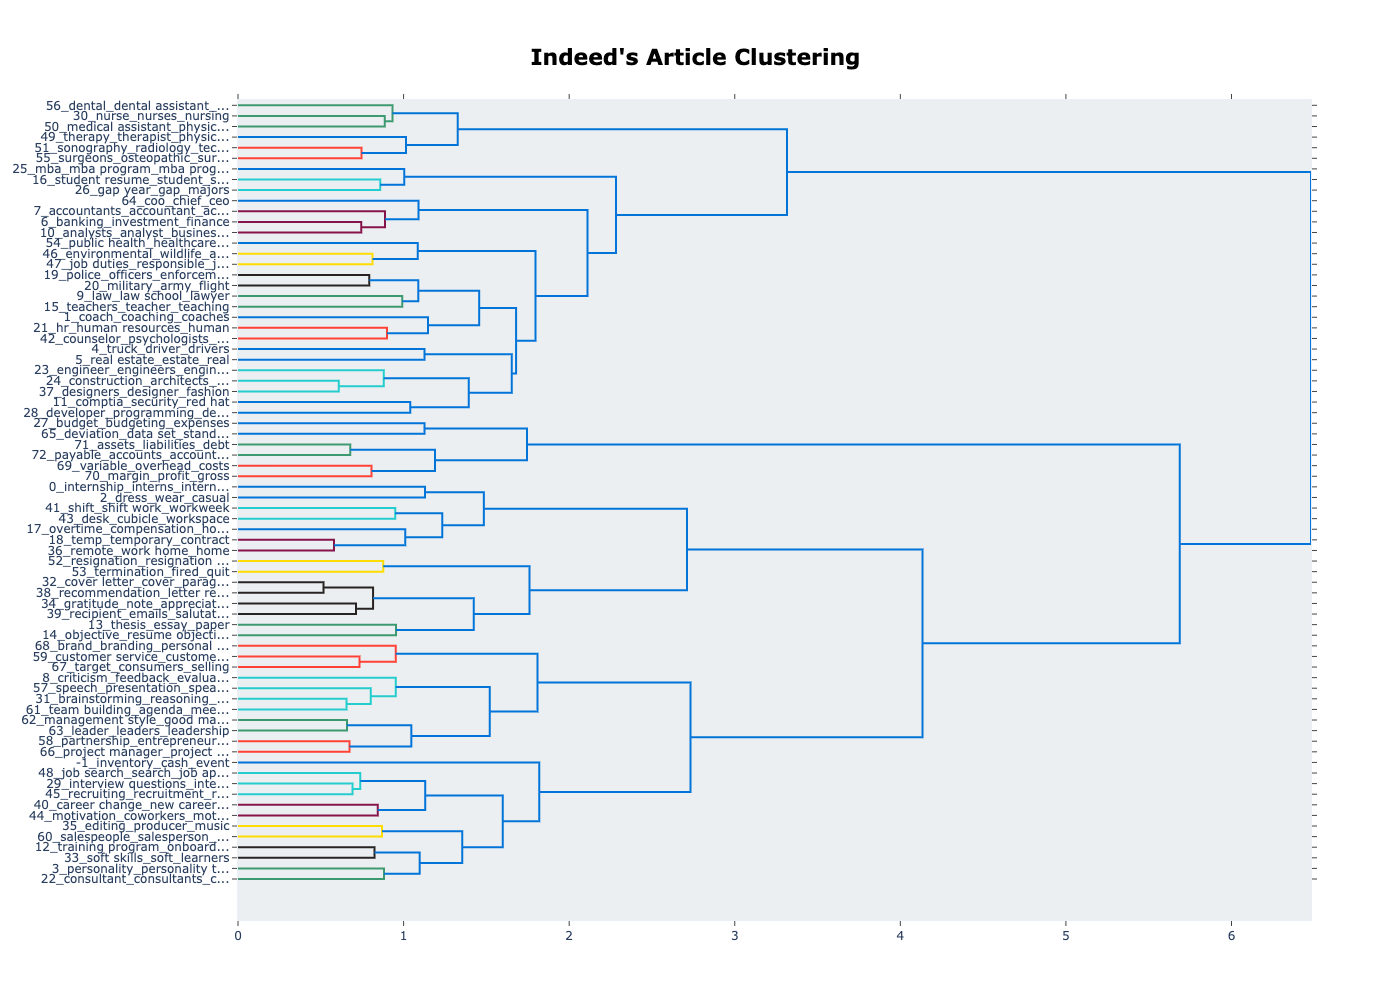

In [33]:
topic_embeddings_74 = create_topic_embeddings(sent_embeddings)
fig = topics_dendrogram(embeddings=topic_embeddings_74)
fig

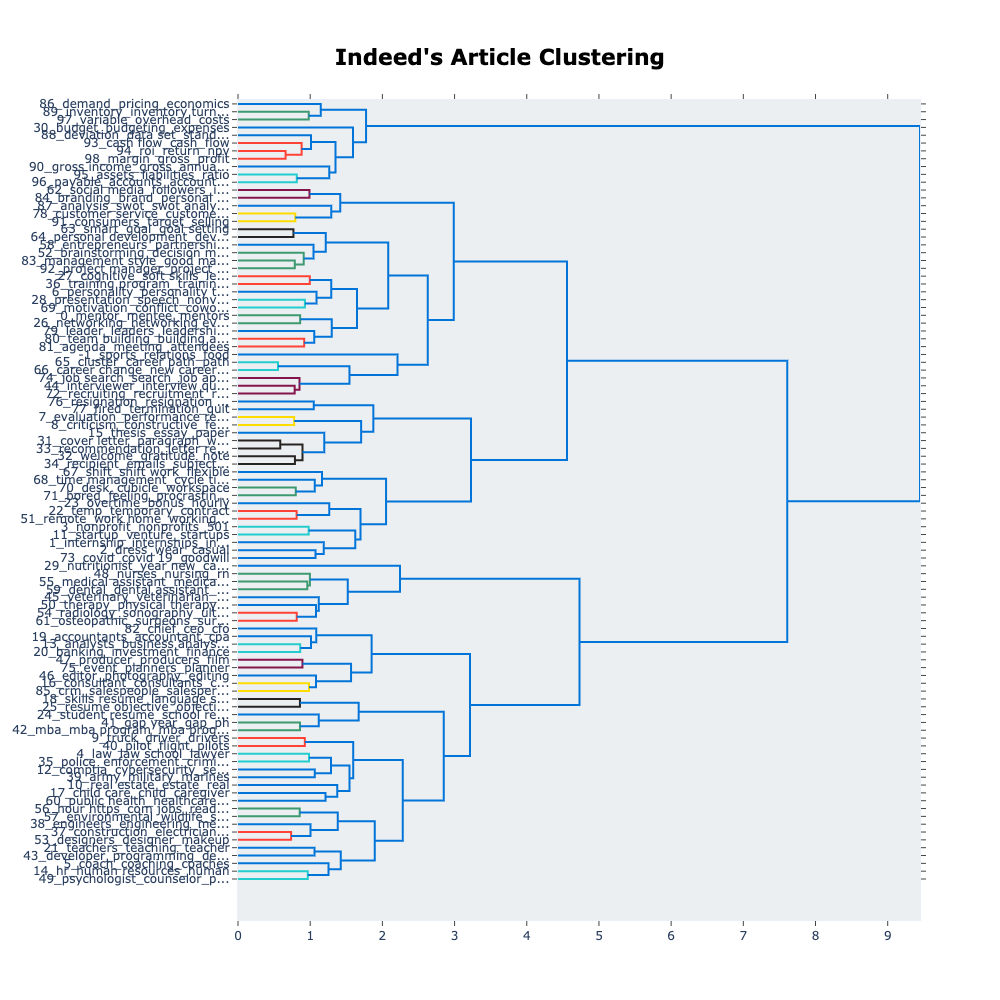

In [39]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (7).png") 

Zoomed in View
--

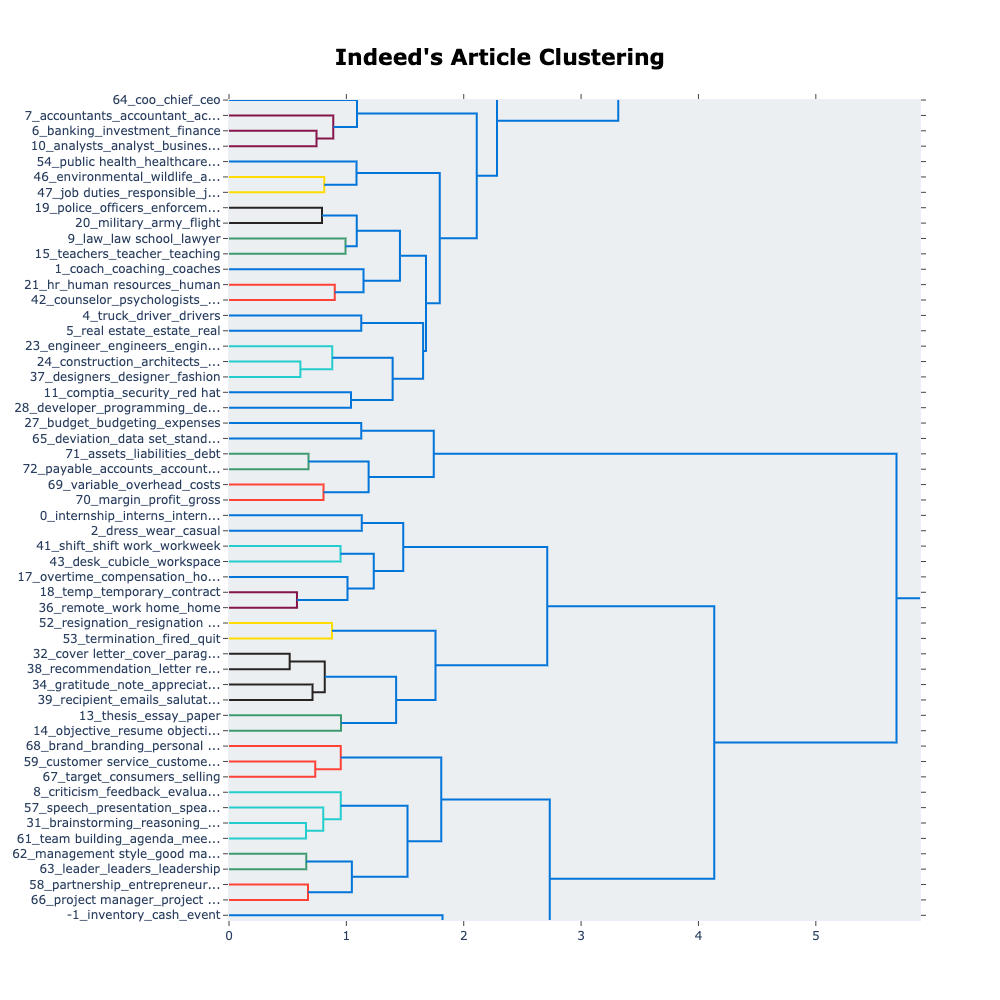

In [34]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (10).png") 

Merging Two Topic (if required)
--
**Note: Only run it if you know what topics to merge, otherwise skip it.** 
**Useful in the case when there are some topics which user wants then to be merged together.**

In [41]:
def merge_topics(topic_to_merge, topic_to_merge_into):
    """
    Merge the Topics if required
    """
    print(f"""
    Topic to be merged {topic_to_merge}:
    {top_10_words[topic_to_merge]}
    Topics to merge into {topic_to_merge_into}:
    {top_10_words[topic_to_merge_into]}
    \n
    """)

    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Title': ' '.join})
    m = len(content)
    tf_idf, count = doc_tf_idf(docs_per_topic.Title.values, m)
    top_words = get_top_n_words(tf_idf, count, docs_per_topic, n=10)
    topic_sizes = get_topic_sizes(docs_df)
    return tf_idf, count, top_words, topic_sizes

tf_idf, count, top_10_words, topic_sizes = merge_topics(topic_to_merge=0,topic_to_merge_into=0)
topic_sizes.head(10)

New articles Predictions using Tf-IDF
--

In [35]:
content = list(art_test["cont_title"])
titles = list(art_test['contentTitle'])

In [36]:
embedding_model = "msmarco-MiniLM-L-12-v3"
device = "cuda" if torch.cuda.is_available else "cpu"
test_embeddings = Sentence_Encoder(embedding_model).embed_documents(content, device=device)

In [37]:
test_embeddings.shape

torch.Size([1417, 384])

In [38]:
test_umap_embeddings = umap_model.transform(test_embeddings)

In [39]:
torch.save(test_umap_embeddings, f"/Users/gurpreetbedi/Downloads/Neural/embeddings/Sent_embeddings/test_umap_embeddings_{len(np.unique(cluster.labels_))}.pt")

In [40]:
test_umap_embeddings.shape

(1417, 10)

In [41]:
predictions, _ = hdbscan.approximate_predict(hdbscan_model, test_umap_embeddings)
probabilities = hdbscan.membership_vector(cluster, test_umap_embeddings)
outlier_score = hdbscan.approximate_predict_scores(hdbscan_model, test_umap_embeddings)

Percentage distribution of Topic with respect to aricles
--

In [42]:
new_preds = defaultdict(list)
top_words = defaultdict(list)

for j, title in enumerate(titles):
    for i in np.argsort(probabilities[j],axis=0)[::-1][:10]:
        new_preds["Title"].append(title)
        words = top_10_words[i]
        check = []
        for word in words:
            check.append(word[0])
        new_preds["Perc"].append(round(probabilities[j][i],5))
        new_preds["Top Words"].append(check)
        
new_df = pd.DataFrame.from_dict(new_preds)

In [43]:
new_df.iloc[:10]

Title     Perc  \
0  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.02145   
1  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01387   
2  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01320   
3  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01304   
4  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01299   
5  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01295   
6  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01289   
7  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01272   
8  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01252   
9  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01227   

                                                                                                                                      Top Words  
0               [interview questions, interviewer, answers, question, interviewers, sample answers, answer, ask question, describe, interviews]  
1  [recruiting, recruitment, recruiters, recruiter, talent, candidates, talent acquisition, recruitment process, recruit, qualified candidates]  
2                                       [team building, agenda, meeting, meetings, participants, attendees, game, teamwork, everyone, together]  
3                      [job search, search, job application, application, searching, new job, applications, postings, job applications, alerts]  
4                    [soft skills, soft, learners, cognitive, multitasking, hard skills, learning, kinesthetic, adaptability, cognitive skills]  
5                                   [motivation, coworkers, motivated, feeling, morale, coworker, adversity, confidence, respect, satisfaction]  
6  [career change, new career, careers, career path, path, career development, change careers, development plan, personal development, cluster]  
7                                               [desk, cubicle, workspace, salad, organize, chicken, productive, decor, organized, polychronic]  
8    [brainstorming, reasoning, deductive, inductive, deductive reasoning, creativity, ideas, ideation, inductive reasoning, problem statement]  
9                               [speech, presentation, speaker, speaking, nonverbal, body language, audience, listening, message, conversation]

In [44]:
new_df.to_csv("/Users/gurpreetbedi/Downloads/Neural/predictions_74_topic_distr.csv")

Approximate pedictions for the test data
--

In [45]:
new_preds = defaultdict(list)
top_words = defaultdict(list)

for j, (title, pred, out) in enumerate(zip(titles, predictions, outlier_score)):
    for i in np.argsort(probabilities[j],axis=0)[::-1][:1]:
        new_preds["Title"].append(title)
        words = top_10_words[pred]
        check = []
        for word in words:
            check.append(word[0])  
        new_preds["Topic"].append(pred)                        
        new_preds["Top_Words"].append(check)
        
new_df = pd.DataFrame.from_dict(new_preds)
print(f"Number of outliers: {len([p for p in new_df.Topic.tolist() if p==-1])}")

Number of outliers: 609


In [46]:
new_df.head(10)

Title  Topic  \
0  How To Tell Someone "That's Not My Job" (With Tips and Examples)     -1   
1             What Is the Theory of Constraints and How Is It Used?     -1   
2     What Is Thinking Strategically? Definition and How To Improve     -1   
3     Thinking vs. Feeling in the Workplace: What's the Difference?      3   
4                               17 Tips for Working With New Bosses     62   
5                   5 To-Do List Methods for Improving Productivity     -1   
6                                    20 DevOps Tools and Their Uses     28   
7   6 of the Toughest Sales Interview Questions with Sample Answers     29   
8               How To Train the Team: Team Training Types and Tips     12   
9                      What Are the Benefits of Six Sigma Training?     -1   

                                                                                                                                                       Top_Words  
0                                                                                  [inventory, cash, event, food, sports, flow, price, demand, goods, insurance]  
1                                                                                  [inventory, cash, event, food, sports, flow, price, demand, goods, insurance]  
2                                                                                  [inventory, cash, event, food, sports, flow, price, demand, goods, insurance]  
3                                                [personality, personality type, tests, assessment, briggs, personality types, myers, myers briggs, infps, test]  
4                          [management style, good manager, theory, leaders, management skills, style, team members, new manager, internal controls, managerial]  
5                                                                                  [inventory, cash, event, food, sports, flow, price, demand, goods, insurance]  
6                                                          [developer, programming, developers, coding, languages, php, programmers, web, front end, javascript]  
7                                [interview questions, interviewer, answers, question, interviewers, sample answers, answer, ask question, describe, interviews]  
8  [training program, onboarding, training programs, sales training, new hire, trainees, employee training, training development, training needs, hire training]  
9                                                                                  [inventory, cash, event, food, sports, flow, price, demand, goods, insurance]

In [47]:
new_df.to_csv("/Users/gurpreetbedi/Downloads/Neural/predictions_74_hard_predictions.csv")

Checking out the if the probability score is different than approximate prediction 
--

In [48]:
new_preds = defaultdict(list)
top_words = defaultdict(list)

for j, (title, pred, out) in enumerate(zip(titles, predictions, outlier_score)):
    for i in np.argsort(probabilities[j],axis=0)[::-1][:1]:
        new_preds["Title"].append(title)
        if probabilities[j][i] < 0.9 :
            words = top_10_words[pred]
        else:
            words = top_10_words[i]
        if probabilities[j][i] < 0.9 :
            new_preds["Topic"].append(pred)  
        else:
            new_preds["Topic"].append(i)            
        check = []
        for word in words:
            check.append(word[0])           
        new_preds["Perc"].append(round(probabilities[j][i],5))
        new_preds["Outlier_score"].append(out)
        new_preds["Top_Words"].append(check)
        
new_df = pd.DataFrame.from_dict(new_preds)
print(f"Number of outliers: {len([p for p in new_df.Topic.tolist() if p==-1])}")

Number of outliers: 589


In [49]:
new_df.head(10)

Title  Topic  \
0  How To Tell Someone "That's Not My Job" (With Tips and Examples)     -1   
1             What Is the Theory of Constraints and How Is It Used?     64   
2     What Is Thinking Strategically? Definition and How To Improve     -1   
3     Thinking vs. Feeling in the Workplace: What's the Difference?      3   
4                               17 Tips for Working With New Bosses     62   
5                   5 To-Do List Methods for Improving Productivity     -1   
6                                    20 DevOps Tools and Their Uses     28   
7   6 of the Toughest Sales Interview Questions with Sample Answers     29   
8               How To Train the Team: Team Training Types and Tips     12   
9                      What Are the Benefits of Six Sigma Training?     -1   

      Perc  Outlier_score  \
0  0.02145       0.039795   
1  0.97241       0.438309   
2  0.30991       0.297321   
3  0.02750       0.639149   
4  1.00000      -0.087605   
5  0.73370       0.083649   
6  0.30164       0.280530   
7  0.94591       0.230933   
8  1.00000      -0.204391   
9  0.14219       0.255708   

                                                                                                                                                       Top_Words  
0                                                                                  [inventory, cash, event, food, sports, flow, price, demand, goods, insurance]  
1                                                                                       [coo, chief, ceo, officer, executive, cfo, ceos, suite, coos, president]  
2                                                                                  [inventory, cash, event, food, sports, flow, price, demand, goods, insurance]  
3                                                [personality, personality type, tests, assessment, briggs, personality types, myers, myers briggs, infps, test]  
4                          [management style, good manager, theory, leaders, management skills, style, team members, new manager, internal controls, managerial]  
5                                                                                  [inventory, cash, event, food, sports, flow, price, demand, goods, insurance]  
6                                                          [developer, programming, developers, coding, languages, php, programmers, web, front end, javascript]  
7                                [interview questions, interviewer, answers, question, interviewers, sample answers, answer, ask question, describe, interviews]  
8  [training program, onboarding, training programs, sales training, new hire, trainees, employee training, training development, training needs, hire training]  
9                                                                                  [inventory, cash, event, food, sports, flow, price, demand, goods, insurance]

In [50]:
new_df.to_csv("/Users/gurpreetbedi/Downloads/Neural/predictions_74_checking with probablities.csv")

In [56]:
titles[1]

'What Is the Theory of Constraints and How Is It Used?'

In [58]:
np.argsort(probabilities[j],axis=0)[::-1][:1]

array([0.00288091, 0.00284364, 0.00403629, 0.02749804, 0.0040628 ,
       0.00393366, 0.00416127, 0.0041399 , 0.00621134, 0.0035268 ,
       0.00449522, 0.00430387, 0.00647252, 0.00566988, 0.00485509,
       0.00422654, 0.0044415 , 0.00458922, 0.00471351, 0.00376666,
       0.00371972, 0.0045217 , 0.00465349, 0.00386935, 0.00409385,
       0.00414096, 0.00425579, 0.00415114, 0.00489456, 0.00643299,
       0.00357035, 0.00599746, 0.00469788, 0.00587457, 0.00538034,
       0.00473213, 0.00458509, 0.00428984, 0.00509194, 0.0054146 ,
       0.00579595, 0.0049883 , 0.00386254, 0.00546861, 0.00593332,
       0.00588883, 0.00398959, 0.00425716, 0.00558815, 0.00368191,
       0.00377714, 0.00375803, 0.00477545, 0.00506459, 0.00391456,
       0.00371247, 0.0036764 , 0.00587836, 0.0048764 , 0.00555417,
       0.00462479, 0.00600706, 0.00534214, 0.00540413, 0.00470378,
       0.00469596, 0.00509834, 0.0046888 , 0.00475307, 0.00404006,
       0.00400102, 0.00386245, 0.00399135])

In [64]:
new_df[new_df["Topic"]!=-1].head(60)

Title  \
1                                   What Is the Theory of Constraints and How Is It Used?   
3                           Thinking vs. Feeling in the Workplace: What's the Difference?   
4                                                     17 Tips for Working With New Bosses   
6                                                          20 DevOps Tools and Their Uses   
7                         6 of the Toughest Sales Interview Questions with Sample Answers   
8                                     How To Train the Team: Team Training Types and Tips   
10                                                      7 Types of Architectural Drawings   
12                                                 26 Types of Beams Used in Construction   
13                                 4 Types of Confined Spaces You Might Encounter at Work   
14                      Algebraic Mathematical Equations: Definitions, Types and Examples   
15                                              9 Types of Fiction Genres (With Examples)   
16                                                             9 Types of Media Marketing   
17                                                     The 4 Types of Nursing Assessments   
19                                                19 Different Types of Psychology Majors   
22                                                14 Common Types of Wood in Construction   
23                                         Five Steps To Help an Underperforming Employee   
27                                                     12 Tips for Leading a Virtual Team   
36                                What Is a Pipefitter? Duties, Skills and Qualifications   
37                                           What Does a Technical Solutions Engineer Do?   
39                                            What Is a Brand Story and How To Create One   
40                                                          What Is a Digital Consultant?   
42                                                What Is a Hazard Communication Program?   
43                                                  What Is a Journeyman? (With Examples)   
44                                                  What Is a Lintel? Definition and FAQs   
47                                             What Is Agribusiness? Definition and Types   
48                                                   What Is an Air Force First Sergeant?   
50                                      What Is an Architect? Everything You Need To Know   
52                              What Is Arbitrage? Types, Examples and Trading Conditions   
55                                       B2B E-commerce: Definition, Types, Pros and Cons   
65                                          What Is an Electrical Engineering Technician?   
67                          What Is Employee Empowerment: Definition, Benefits and How-To   
68                               What Is Evidence-Based Practice? Definition and Elements   
69                                What Is a GMP Contract and What Are Its Major Benefits?   
70                                                   What Does a Reliability Engineer Do?   
71                                 What Is a Micro-Enterprise and Why Are They Important?   
73                                                             What Is an Ocean Engineer?   
75                           What Is a Photography Director? (Plus Tips for Becoming One)   
77                                  Professional Coach: Definition, Duties and Advantages   
78                                     What Is Salaries Payable? Definitions and Examples   
82                          What Is a Sport Psychologist? Definition and Responsibilities   
83                                        What Is Structural Design in Civil Engineering?   
85                       What is a Trainee Accountant? Definition, Skills and Job Outlook   
87                                                    What Is a Water Treatment Engin